# Engines to test:
## 1. Tesseract
## 2. PaddleOCR
## 3. EasyOCR

# Dataset

https://guillaumejaume.github.io/FUNSD/

In [3]:
import os
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import time

annotations_folder = '/home/maxkhamuliak/projects/OCR-comparsion/annotations'
images_folder = '/home/maxkhamuliak/projects/OCR-comparsion/images'

data = []

for filename in os.listdir(annotations_folder):
    if filename.endswith('.json'):
        with open(os.path.join(annotations_folder, filename), 'r') as file:
            annotation_data = json.load(file)
            image_filename = filename.split('.')[0] + '.png'
            text = ""
            for item in annotation_data['form']:
                text += item['text'] + " "

            data.append({'filename': image_filename, 'text': text.strip()})

df = pd.DataFrame(data)

df.head()


,filename,text
0,82092117.png,TO: DATE: 3 Fax: NOTE: 82092117 614 -466 -5087...
1,82200067_0069.png,TO: FROM: x SUBJECT: DIVISION: DIVISION: DIV...
2,82250337_0338.png,TO: FROM: DATE: MANUFACTURER: BRAND: Oct. Dec....
3,82251504.png,17 cc: : From: Area: Region: 5 X Chains: Indep...
4,82252956_2958.png,AUG 4 SEP 15 JUN 23 MAY 12 REGION: DIVISION: 7...


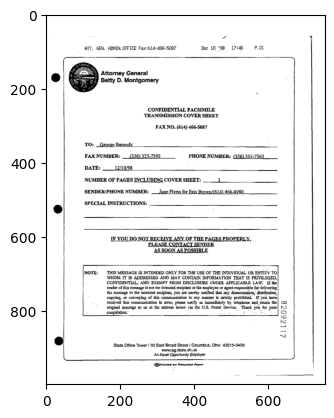

In [4]:
imgs_path = "/home/maxkhamuliak/projects/OCR-comparsion/images/"
img = cv2.imread(imgs_path + "82092117.png")
plt.imshow(img)

## Tesseract


In [13]:
!pip install pytesseract

In [14]:
import pytesseract


In [15]:
def IoU(s1, s2):
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [16]:
IoUs_tess = []
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = set(pytesseract.image_to_string(img,lang = 'eng').replace('\n',' ').split(" "))
    gt = set(df[df['filename'] == row['filename']]['text'].values[0].split(" "))
    IoUs_tess.append(IoU(pt_output, gt))
fin = time.time()
n = len(df)
avg_tess_time = (fin - start)/n

In [17]:
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = pytesseract.image_to_string(img,lang = 'eng')
fin = time.time()
n = len(df)
avg_tess_time_no_prep = (fin - start)/n

In [18]:
import numpy as np
np.array(IoUs_tess).mean()

0.3867055006394851

In [19]:
(np.array(IoUs_tess) > 0.5).mean()

0.2

## PaddleOCR

In [1]:
from paddleocr import PaddleOCR

ModuleNotFoundError: No module named 'paddle'

In [9]:
pocr_model = PaddleOCR(lang='en')


[2024/06/13 18:37:47] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/maxkhamuliak/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/maxkhamuliak/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, 

ValueError: (InvalidArgument) Device id must be less than GPU count, but received id is: 0. GPU count is: 0.
  [Hint: Expected id < GetGPUDeviceCount(), but received id:0 >= GetGPUDeviceCount():0.] (at /paddle/paddle/phi/backends/gpu/cuda/cuda_info.cc:255)


In [50]:
def extract_text_from_output(output_list, easy=False):
    extracted_text = ""
    for item in output_list:
        if easy:
            text = item[1] if isinstance(item, tuple) and len(item) > 1 else ""
        else:
            text = item[1][0] if isinstance(item, tuple) and len(item) > 1 and isinstance(item[1], list) and len(item[1]) > 0 else ""
        
        if isinstance(text, str):
            extracted_text += text + " "
        else:
            print(f"Unexpected format for text extraction: {item}")

    return extracted_text.strip()


In [51]:
IoUs_paddle = []
start = time.time()
for index, row in df.iterrows():
    # Reading the image file
    img_path = os.path.join(imgs_path, row['filename'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image: {img_path}")
        continue

    # Performing OCR on the image
    try:
        ocr_output = pocr_model.ocr(img)
        pt_output = set(extract_text_from_output(ocr_output).split(" "))
    except Exception as e:
        print(f"Error during OCR or text extraction for {img_path}: {e}")
        continue

    # Calculating IoU
    gt_text = df[df['filename'] == row['filename']]['text'].values[0]
    gt_set = set(gt_text.split(" "))
    current_IoU = IoU(pt_output, gt_set)
    IoUs_paddle.append(current_IoU)

    # Debugging output
    print(f"Processed {img_path}")
    print(f"Predicted text: {pt_output}")
    print(f"Ground truth text: {gt_set}")
    print(f"IoU: {current_IoU}")

fin = time.time()
print(f"Total processing time: {fin - start}s")
print(f"Average IoU across documents: {sum(IoUs_paddle) / len(IoUs_paddle) if IoUs_paddle else 0}")


[2024/06/07 16:37:02] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


[2024/06/07 16:37:03] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.4454514980316162
[2024/06/07 16:37:11] ppocr DEBUG: rec_res num  : 44, elapsed : 7.88144588470459
Processed /home/maxkhamuliak/projects/OCR-comparsion/images/82092117.png
Predicted text: {''}
Ground truth text: {'', 'Broad', 'communication', 'TRANSMISSION', 'reader', 'NOTE:', 'Ohio', 'not', 'responsible', 'IS', 'S.', 'intended', 'UNDER', 'IF', 'State', 'PHONE', 'FACSIMILE', 'Postal', 'Office', 'Primed', '43215', 'comunication', '466-', 'FROM', 'Columbus,', 'COVER', 'notify', '-466', 'have', 'in', 'at', 'oh', 'telephone', 'your', 'Betty', '5087', 'INTENDED', 'DISCLOSURE', 'FAX', 'If', 'THAT', 'us', 'address', 'Street/', 'TO:', 'CONTAIN', 'below', 'NO.', 'prohibited.', 'APPLICABLE', 'please', 'via', 'SPECIAL', 'you', 'cooperation.', 'SHEET', 'OF', 'ANY', 'OFFICE', 'June', 'for', 'of', 'TO', 'to', 'an', 'PROPERLY,', '(336)', 'ADMIN.', 'AND', 'Tower', '/10', 'P.', 'General', 'Dec', 'OR', 'copying,', 'message', 'or', 'U.', 'M

KeyboardInterrupt: 

In [29]:
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = pocr_model.ocr(img)
fin = time.time()
avg_paddle_time_no_prep = (fin - start)/n

[2024/06/07 14:35:13] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/07 14:35:14] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.5211524963378906
[2024/06/07 14:35:24] ppocr DEBUG: rec_res num  : 44, elapsed : 9.763110160827637
[2024/06/07 14:35:24] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/07 14:35:24] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.42426037788391113
[2024/06/07 14:35:33] ppocr DEBUG: rec_res num  : 71, elapsed : 8.958205461502075
[2024/06/07 14:35:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/06/07 14:35:34] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.4081852436065674
[2024/06/07 14:35:43] ppocr DEBUG: rec_res num  : 51, elapsed : 9.609104871749878
[2024/06/07 14:35:43] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during 

In [30]:
avg_paddle_time = (fin - start)/n

In [31]:
np.array(IoUs_paddle).mean()

0.0049253818149828064

In [32]:
(np.array(IoUs_paddle) > 0.5).mean()

0.0

## EasyOCR

In [33]:
!pip install easyocr


In [34]:
import easyocr

In [35]:
reader = easyocr.Reader(['en', 'en'])

[2024-06-07 14:41:44,683] [ WARNING] easyocr.py:80 - Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
[2024-06-07 14:41:45,002] [ WARNING] easyocr.py:176 - Downloading recognition model, please wait. This may take several minutes depending upon your network connection.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [37]:
def extract_text_from_easy(output_list, easy=False):
    extracted_text = ""
    for item in output_list:
        if easy:
            text = item[1]
        else:
            text = item[1][0]
        extracted_text += text + " "
    return extracted_text.strip()

In [38]:
IoUs_easy = []
start = time.time()
for _, row in df.iterrows():
    output = reader.readtext(imgs_path  + row['filename'])
    pt_output = set(extract_text_from_easy(output, easy=True).split(" "))
    gt = set(df[df['filename'] == row['filename']]['text'].values[0].split(" "))
    IoUs_easy.append(IoU(pt_output, gt))
fin = time.time()

In [39]:
start = time.time()
for _, row in df.iterrows():
    output = reader.readtext(imgs_path + row['filename'])
fin = time.time()
avg_easy_time_no_prep = (fin - start)/n

In [40]:
avg_easy_time = (fin - start)/n

In [41]:
np.array(IoUs_easy).mean()

0.31378197007381675

In [42]:
(np.array(IoUs_easy) > 0.5).mean()

0.1

## Comparison table

In [43]:
comp_df = pd.DataFrame([{"engine": "Tesseract", "average IoU": np.array(IoUs_tess).mean(), "accuracy": (np.array(IoUs_tess) > 0.5).mean(), "average time": avg_tess_time, "average time no prep": avg_tess_time_no_prep},
                        {"engine": "PaddleOCR", "average IoU": np.array(IoUs_paddle).mean(), "accuracy": (np.array(IoUs_paddle) > 0.5).mean(), "average time": avg_paddle_time, "average time no prep": avg_paddle_time_no_prep},
                        {"engine": "EasyOCR", "average IoU": np.array(IoUs_easy).mean(), "accuracy": (np.array(IoUs_easy) > 0.5).mean(), "average time": avg_easy_time, "average time no prep": avg_easy_time_no_prep}])

In [44]:
comp_df

,engine,average IoU,accuracy,average time,average time no prep
0,Tesseract,0.386706,0.2,1.253941,1.212037
1,PaddleOCR,0.004925,0.0,7.577919,7.577919
2,EasyOCR,0.313782,0.1,32.071933,32.071933
